

<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>






### Intuition Behind MCMC Sampling: Comparison With Analytical Solutions Using Metropolis and Hamiltonian Approaches

#### Sohini Dasgupta
#### Institute for Geophysics, Department of Earth and Planetary Sciences, University of Texas at Austin

### Subsurface Machine Learning Course, The University of Texas at Austin

_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Lei Liu, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/misaelmmorales/)


### Executive Summary

MCMC methods are useful for estimating probability distributions that are computationally heavy and/or have no defined analytical solution to be easily calculated. The problem/gap is to be discussed is if MCMC can approximate the posterior close enough to the real solution.
I take this opportunity to demonstrate the intuition behind the MCMC sampling using two sampling algoritms i.e, Metropolis and Hamiltonian approaches and estimate the posterior of the mean from some random points of a normal distribution (standard deviation assumed to be 1 here) and compare it the analytical solution.  I also compare the sensitivity in choosing the correct proposal widths 

The following code block is from Thomas Wiecki [https://github.com/twiecki]
(https://github.com/twiecki/WhileMyMCMCGentlySamples/blob/master/content/downloads/notebooks/MCMC-sampling-for-dummies.ipynb). I have modified and included Hamiltonian algorithm in addition to this code block.

### Introduction


To address the issue with posterior estimation from high dimensional/hard to calculate situations, we used MCMC algorithm to get approximate solutions.
MCMC works really good to estimate posteriors in situations when the closed form solution is impossible to calculate directly. If we sample for long, we can get to the closed form solution irrespective of the sampling method used. MCMC methods excel in sampling from high-dimensional or continuous random process distributions, and they are ideal for optimization in non random processes where evaluating all possible configurations is infeasible.

The Metropolis–Hastings algorithm is a Markov chain Monte Carlo (MCMC) method for obtaining a sequence of random samples from a probability distribution from which direct sampling is difficult. Metropolis-Hastings needs four elements: a starting point, a target distribution, a proposal distribution, and an impartial judge (a random event).

The Hamiltonian Monte Carlo algorithm is a Markov chain Monte Carlo method for obtaining a sequence of random samples which converge to being distributed according to a target probability distribution for which direct sampling is difficult. This corresponds to an instance of the Metropolis–Hastings algorithm, with a Hamiltonian dynamics evolution simulated using a time-reversible and volume-preserving numerical integrator (typically the leapfrog integrator) to propose a move to a new point in the state space. Compared to using a Gaussian random walk proposal distribution in the Metropolis–Hastings algorithm, Hamiltonian Monte Carlo reduces the correlation between successive sampled states by proposing moves to distant states which maintain a high probability of acceptance due to the approximate energy conserving properties of the simulated Hamiltonian dynamic when using a symplectic integrator. The reduced correlation means fewer Markov chain samples are needed to approximate integrals with respect to the target probability distribution for a given Monte Carlo error.

### My Workflow


This workflow demonstrates MCMC sampling using two methods and develops an intuitive explanation for how the approximated posteriors compare with the analytical solution.
It talks about proposal widths and summarises results based on the code here. 

This is a general workflow and can be run on any kind of distributions.

In [67]:
# Import Packages
%matplotlib inline

hide_warnings = True
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
supress_warnings = False
# if supress_warnings == True:
#     import warnings                                       # supress any warnings for the demonstration
#     warnings.filterwarnings('ignore') 
import warnings
if hide_warnings == True:
    warnings.filterwarnings('ignore')

from scipy.stats import norm
sns.set_style('white')
sns.set_context('talk')

The data to be used for this workflow is to be randomly generated froma  normal distribution centered around zero using python np.random.randn() command.


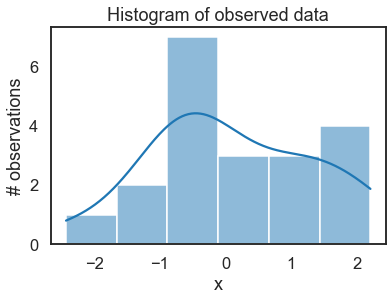

In [68]:
# Load Data
np.random.seed(123)
data = np.random.randn(20)

# Plot histogram of data
ax = plt.subplot()
sns.histplot(data, kde=True, ax=ax)
_ = ax.set(title='Histogram of observed data', xlabel='x', ylabel='# observations');

Visualising the summary statistics of the randomly generated numpy data

In [69]:
# Calculate summary statistics
mean_value = np.mean(data)
median_value = np.median(data)
std_dev = np.std(data)
min_value = np.min(data)
max_value = np.max(data)

# Print summary statistics
print(f"Mean: {mean_value}")
print(f"Median: {median_value}")
print(f"Standard Deviation: {std_dev}")
print(f"Minimum: {min_value}")
print(f"Maximum: {max_value}")

Mean: 0.11441773195529023
Median: -0.2618107988965342
Standard Deviation: 1.2256132687404364
Minimum: -2.426679243393074
Maximum: 2.2059300827254558


### Model Definition
We assume that this data is normal distributed, i.e. the likelihood of the model is normal. For simplicity, we assume that $\sigma = 1$ is known and we want to infer the posterior for $\mu$.  For simplicity, lets also assume  a normal distribution as a prior for $\mu$ given as:

$$\mu \sim \text{Normal}(0, 1)\\
x|\mu \sim \text{Normal}(x; \mu, 1)$$

For a normal likelihood with known standard deviation, the normal prior for `mu` is [**conjugate**](https://en.wikipedia.org/wiki/Conjugate_prior) meaning the posterior will follow the same distribution as the prior. Thus,  posterior for $\mu$ is also normal. This is our analytical solution for the posterior.

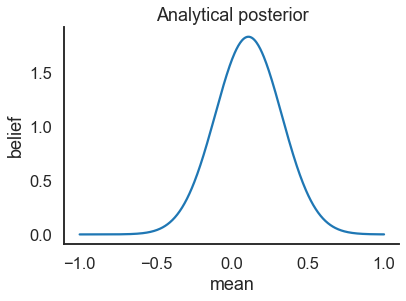

In [70]:
# Analytical posterior definition

def calc_posterior_analytical(data, x, mu_0, sigma_0):
    sigma = 1.
    n = len(data)
    mu_post = (mu_0 / sigma_0**2 + data.sum() / sigma**2) / (1. / sigma_0**2 + n / sigma**2)
    sigma_post = (1. / sigma_0**2 + n / sigma**2)**-1
    return norm(mu_post, np.sqrt(sigma_post)).pdf(x)

ax = plt.subplot()
x = np.linspace(-1, 1, 500)
posterior_analytical = calc_posterior_analytical(data, x, 0., 1.)
ax.plot(x, posterior_analytical)
ax.set(xlabel='mean', ylabel='belief', title='Analytical posterior');
sns.despine()

But in reality, these assumptions can deviate and therefore it is not possible to get clear analytical solutions for all cases. 

### Metropolis- Hastings Algorithm

Steps for Metropolis sampler:
1. Set arbitrary values for the mean

```python
mu_current = 1.
```

2.  Propose to jump from that position somewhere else (Markov part).  
The Metropolis sampler is very dumb and just takes a sample from a normal distribution centered around  `mu_current` with a certain `proposal_width` determining the jump

```python
proposal = norm(mu_current, proposal_width).rvs()
```

3. Evaluate whether to jump to or not. 
If the resulting normal distribution with that proposed `mu` explaines the data better than your old `mu`, we go there. The fit is quantified by computing the probability of the data, given the likelihood with the proposed parameter values (proposed `mu` and a fixed `sigma = 1`). 

```python
likelihood_current = norm(mu_current, 1).pdf(data).prod()
likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
```        
4. Compute prior probability of current and proposed mu   
```python
prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
```  
5. Baye's formula
```python
p_current = likelihood_current * prior_current
p_proposal = likelihood_proposal * prior_proposal
```
Eventually we'll get to `mu = 0` (or close to it) from where no more moves will be possible. The key trick is by dividing the two probabilities,

```python
p_accept = p_proposal / p_current
```

we get an acceptance probability. If `p_proposal` is larger, that probability will be `> 1` and we'll accept. If `p_current` is larger, say twice as large, there'll be a 50% chance of moving there:

```python
accept = np.random.rand() < p_accept

if accept:
    # Update position
    cur_pos = proposal

```

Basically, dividing the posterior of proposed parameter setting by the posterior of the current parameter setting, $P(x)$ canceled out which is the harder part to compute. So we can intuit that we're actually dividing the full posterior at one position by the full posterior at another position. That way, we are visiting regions of high posterior probability relatively more often than those of low posterior probability.

In [71]:
# Function to define the Metropolis sampler
def metropolis_sampler(data, samples=10, mu_init=.5, proposal_width=.5, plot=False, mu_prior_mu=0, mu_prior_sd=1.):
    mu_current = mu_init
    posterior = [mu_current]
    for i in range(samples):
        # suggest new position
        mu_proposal = norm(mu_current, proposal_width).rvs()

        # Compute likelihood by multiplying probabilities of each data point
        likelihood_current = norm(mu_current, 1).pdf(data).prod()
        likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
        
        # Compute prior probability of current and proposed mu        
        prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
        prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
        
        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal
        
        # Accept proposal?
        p_accept = p_proposal / p_current
        
        # Usually would include prior probability, which we neglect here for simplicity
        accept = np.random.rand() < p_accept
        
        if plot:
            plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accept, posterior, i)
        
        if accept:
            # Update position
            mu_current = mu_proposal
        
        posterior.append(mu_current)
        
    return np.array(posterior)


### Hamiltonian Monte Carlo Algorithm


Steps for Hamiltonian sampler:
1. Set arbitrary values for the mean

```python
mu_current = 1.
```
Set L(numbe rof leapfrog steps)

2.  Randomly sample the initial momentum from a standard normal distribution.  

```python
for i in range(samples):
        # Sample random momentum
        r_current = np.random.normal(0, 1)
```

3. Make a half step for momentum at the beginning

4. Make a half-step for the momentum using the gradient of the log-prior.  

```python
r_proposal = r_current - epsilon * (-(1 / mu_prior_sd ** 2) * (mu_current - mu_prior_mu))
```        
5. Alternate full steps for updating the position (mu_proposal) and momentum (r_proposal), done using the leapfrog method, where the position and momentum are updated in a series of small steps.   
```python
mu_proposal = mu_current
        for j in range(L):
            mu_proposal = mu_proposal + epsilon * r_proposal
```  
6. Negate the momentum at the end of the trajectory to ensure the proposal is symmetric

7. Compute the energies for the current and proposed states. 
These energies involve the negative log-likelihood of the data and the kinetic energy term (related to the momentum).

8. Accept or reject the proposal


In [72]:
# Function to define the Hamiltonian sampler

def hamiltonian_sampler(data, samples=10, mu_init=0.5, epsilon=0.01, L=100, mu_prior_mu=0, mu_prior_sd=1, plot=False):
    mu_current = mu_init
    posterior = [mu_current]

    for i in range(samples):
        # Sample random momentum
        r_current = np.random.normal(0, 1)

        # Make a half step for momentum at the beginning
        r_proposal = r_current - epsilon * (-(1 / mu_prior_sd ** 2) * (mu_current - mu_prior_mu))

        # Alternate full steps for position and momentum
        mu_proposal = mu_current
        for j in range(L):
            mu_proposal = mu_proposal + epsilon * r_proposal
            # Make a full step for the momentum, except at the end of trajectory
            if j < L - 1:
                r_proposal = r_proposal - epsilon * (-(1 / mu_prior_sd ** 2) * (mu_proposal - mu_prior_mu))

        # Negate the momentum at the end of the trajectory to make the proposal symmetric
        r_proposal = -r_proposal

        # Compute energies
        current_energy = -np.log(norm(mu_current, mu_prior_sd).pdf(data)).sum() - 0.5 * r_current ** 2
        proposal_energy = -np.log(norm(mu_proposal, mu_prior_sd).pdf(data)).sum() - 0.5 * r_proposal ** 2

        # Accept/reject the proposal
        alpha = min(1, np.exp(current_energy - proposal_energy))
        u = np.random.uniform(0, 1)
        if u < alpha:
            mu_current = mu_proposal

        if plot:
            plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, u < alpha, posterior, i)

        posterior.append(mu_current)

    return np.array(posterior)

Let's visualise prior, liklihood and posterior below with each row being a single iteration through our samplers. 

The first column is the prior distribution  ($\mu$ is before seeing the data). The distribution is static and only $\mu$ proposals are plugged in. The vertical lines represent our current $\mu$ in blue and our proposed $\mu$ in either red or green (rejected or accepted, respectively). 

The 2nd column is the likelihood and what we are using to evaluate how good our model explains the data. It changes in response to the proposed $\mu$. The blue histogram which is our data. The solid line in green or red is the likelihood with the currently proposed `mu`. The  more overlap there is between likelihood and data, the better the model explains the data and the higher the resulting probability will be. The dotted line of the same color is the proposed `mu` and the dotted blue line is the current `mu`.

The 3rd column is the posterior distribution. Here I am displaying the normalized posterior. 

We are always moving to relatively more likely $\mu$ values, but only sometimes to relatively less likely $\mu$ values.

In [73]:
# Function to display

def plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accepted, trace, i):
    from copy import copy
    trace = copy(trace)
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20, 3))
    fig.legend('Iteration %i' % (i + 1))
    x = np.linspace(-3, 3, 5000)
    color = 'g' if accepted else 'r'
        
    # Plot prior
    prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
    prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
    prior = norm(mu_prior_mu, mu_prior_sd).pdf(x)
    ax1.plot(x, prior)
    ax1.plot([mu_current] * 2, [0, prior_current], marker='o', color='b')
    ax1.plot([mu_proposal] * 2, [0, prior_proposal], marker='o', color=color)
    ax1.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->",color='black', lw=2.))
    ax1.set(ylabel='Probability Density', title='current: prior(mean=%.2f) = %.2f\nproposal: prior(mean=%.2f) = %.2f' % (mu_current, prior_current, mu_proposal, prior_proposal))
    
    # Likelihood
    likelihood_current = norm(mu_current, 1).pdf(data).prod()
    likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
    y = norm(loc=mu_proposal, scale=1).pdf(x)
    sns.histplot(data, kde=False, ax=ax2)
    ax2.plot(x, y, color=color)
    ax2.axvline(mu_current, color='b', linestyle='--', label='mu_current')
    ax2.axvline(mu_proposal, color=color, linestyle='--', label='mu_proposal')
    #ax2.title('Proposal {}'.format('accepted' if accepted else 'rejected'))
    ax2.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->",color='black',lw=2.))
    ax2.set(title='likelihood(mean=%.2f) = %.2f\nlikelihood(mean=%.2f) = %.2f' % (mu_current, 1e14*likelihood_current, mu_proposal, 1e14*likelihood_proposal))
    
    # Posterior
    posterior_analytical = calc_posterior_analytical(data, x, mu_prior_mu, mu_prior_sd)
    ax3.plot(x, posterior_analytical)
    posterior_current = calc_posterior_analytical(data, mu_current, mu_prior_mu, mu_prior_sd)
    posterior_proposal = calc_posterior_analytical(data, mu_proposal, mu_prior_mu, mu_prior_sd)
    ax3.plot([mu_current] * 2, [0, posterior_current], marker='o', color='b')
    ax3.plot([mu_proposal] * 2, [0, posterior_proposal], marker='o', color=color)
    ax3.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->",color='black', lw=2.))
    #x3.set(title=r'prior x likelihood $\propto$ posterior')
    ax3.set(title='posterior(mean=%.2f) = %.5f\nposterior(mean=%.2f) = %.5f' % (mu_current, posterior_current, mu_proposal, posterior_proposal))
    
    if accepted:
        trace.append(mu_proposal)
    else:
        trace.append(mu_current)

Displaying below the results of the Metropolis Hastings MCMC algorithm.

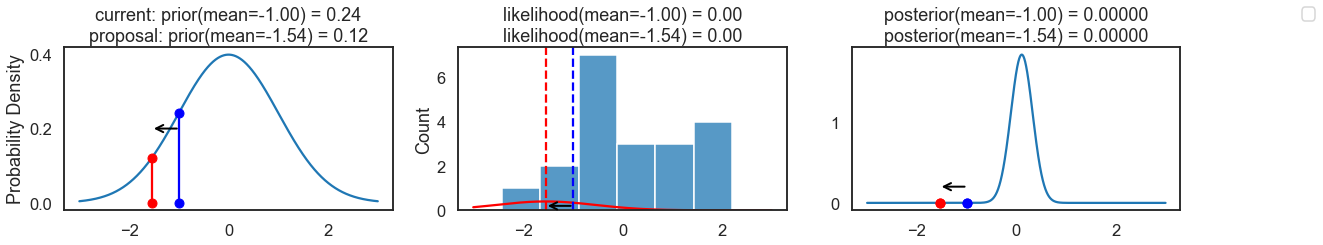

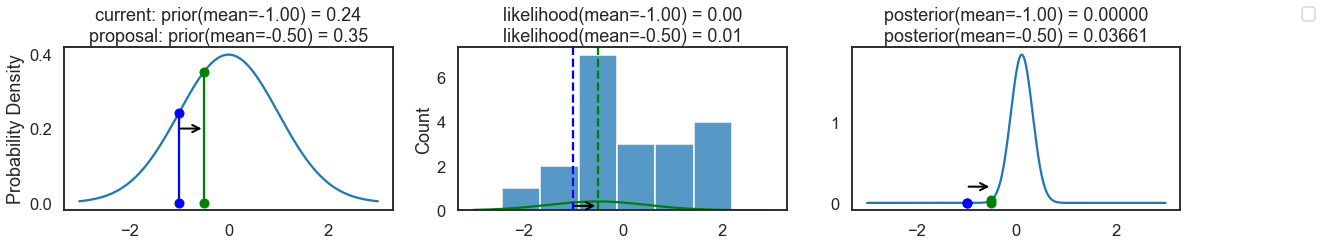

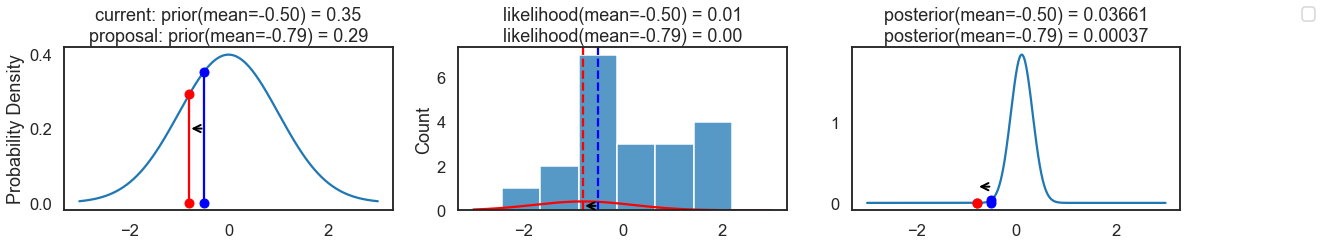

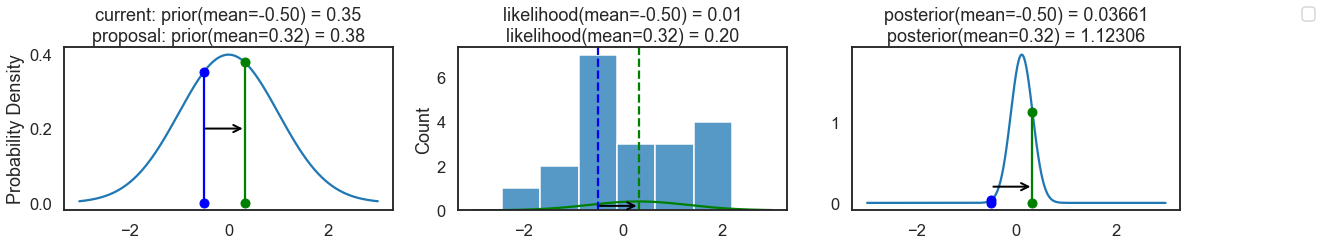

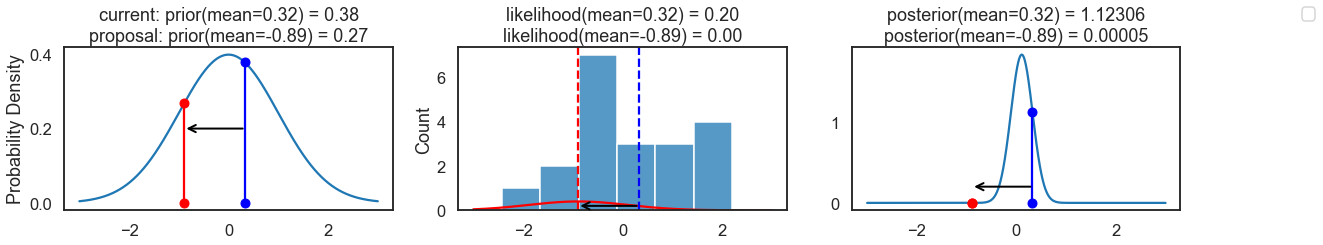

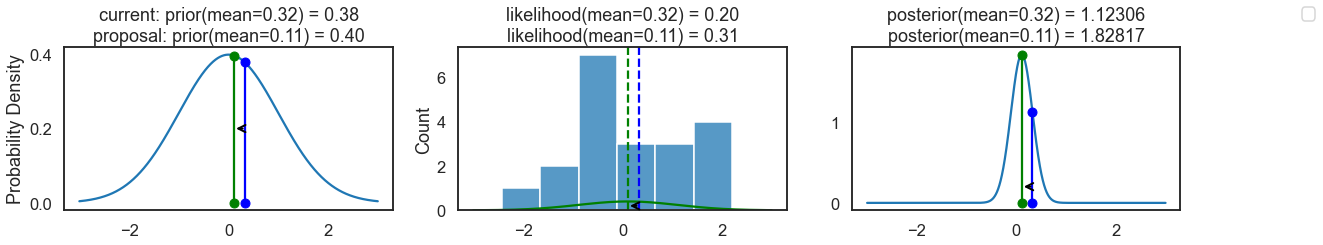

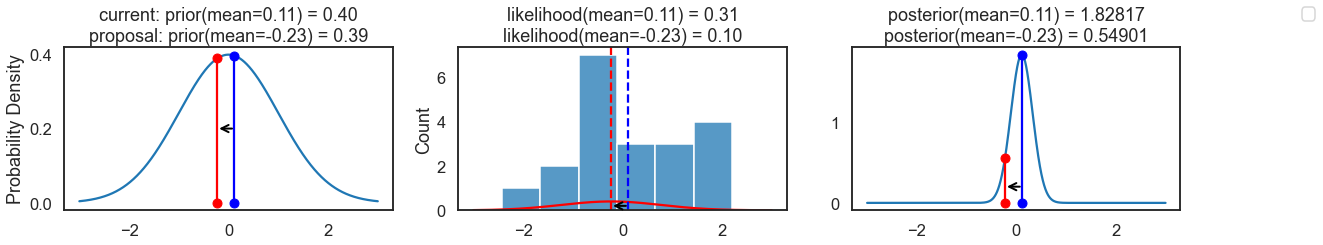

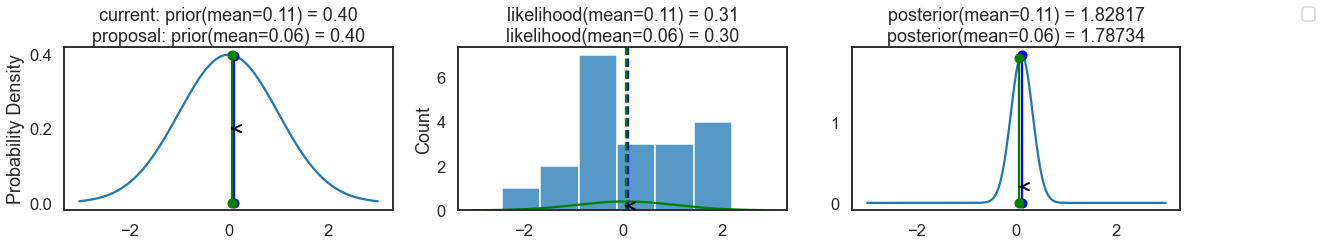

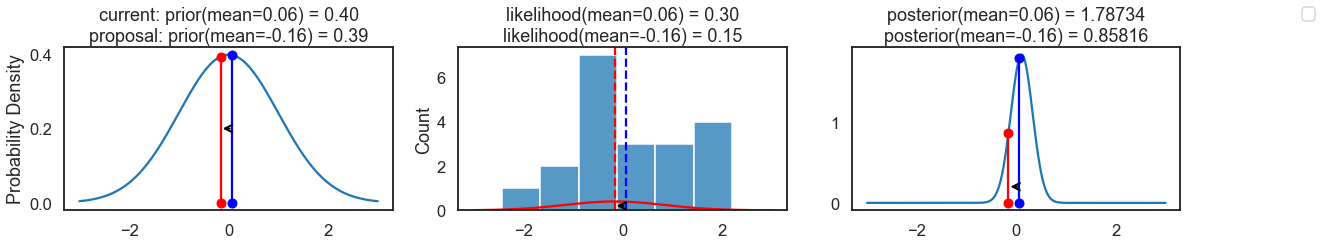

In [74]:
np.random.seed(123)
metropolis_sampler(data, samples=9, mu_init=-1., plot=True);

Displaying below the results of the Hamiltonian MCMC algorithm.

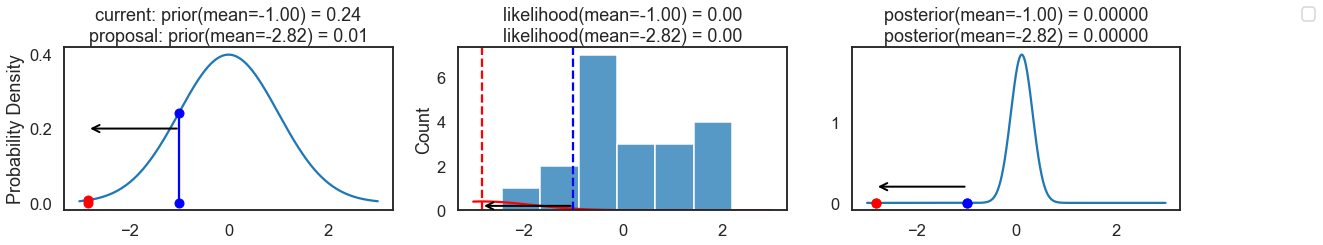

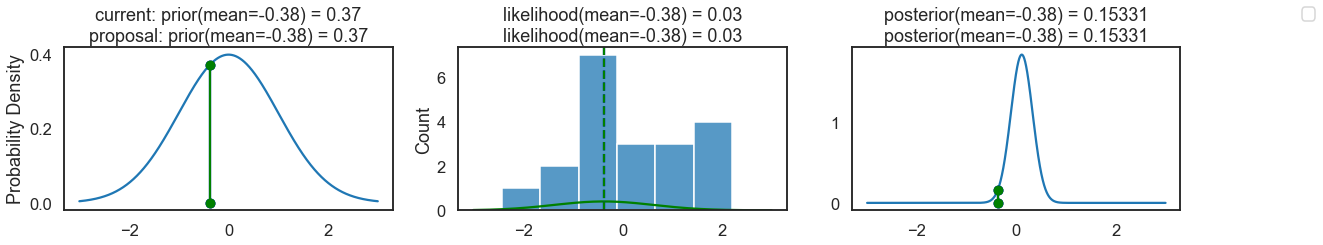

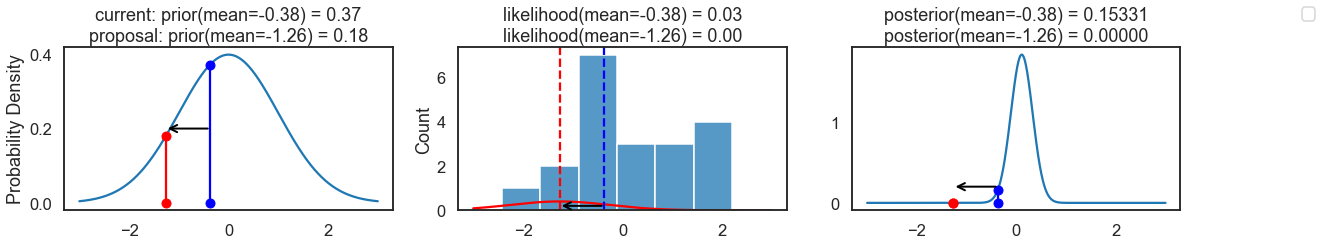

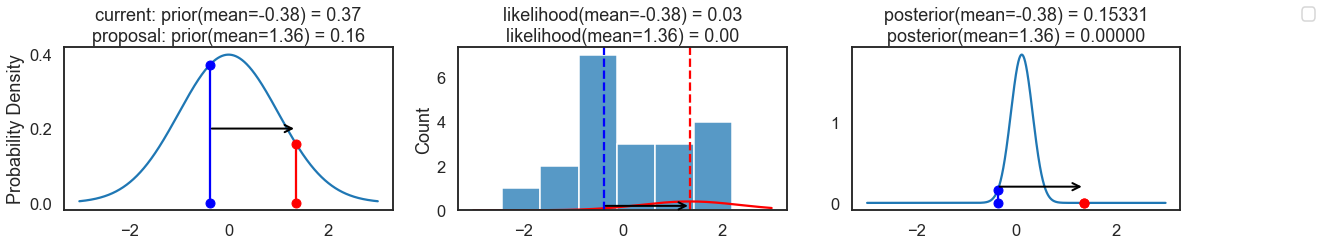

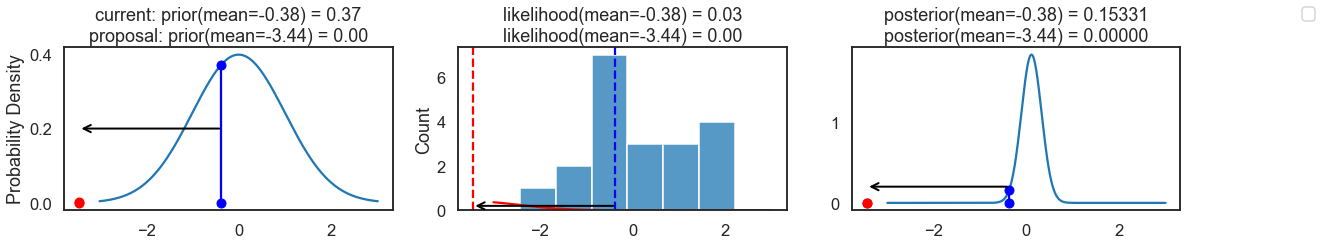

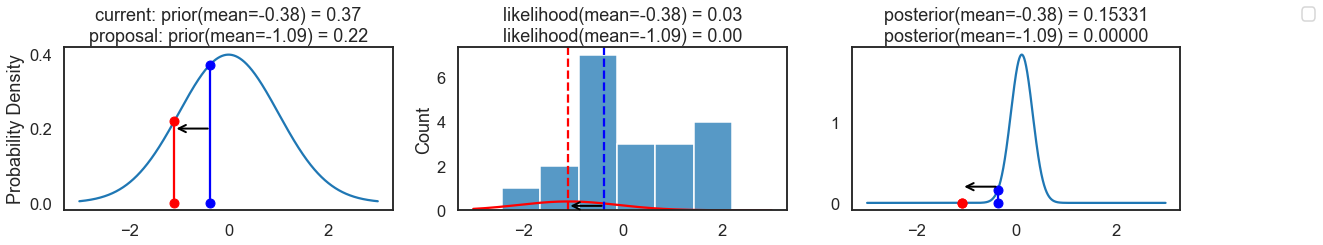

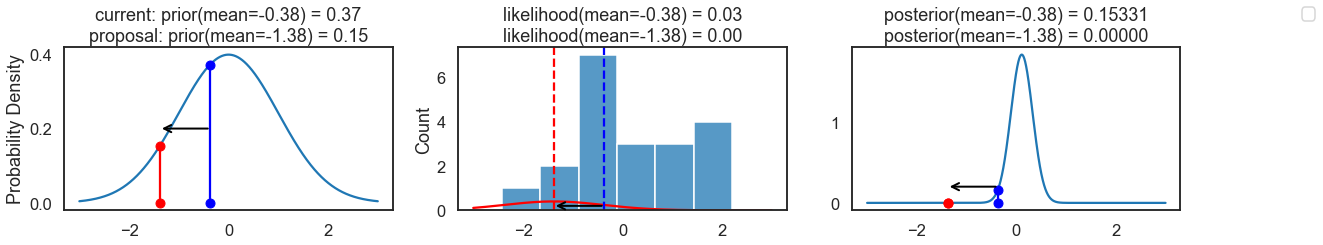

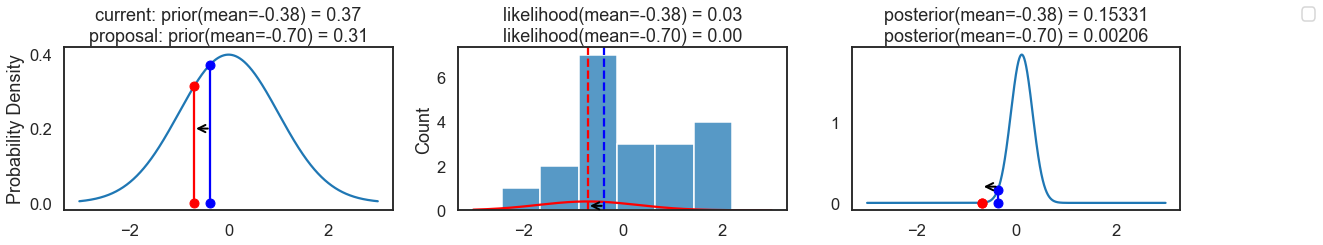

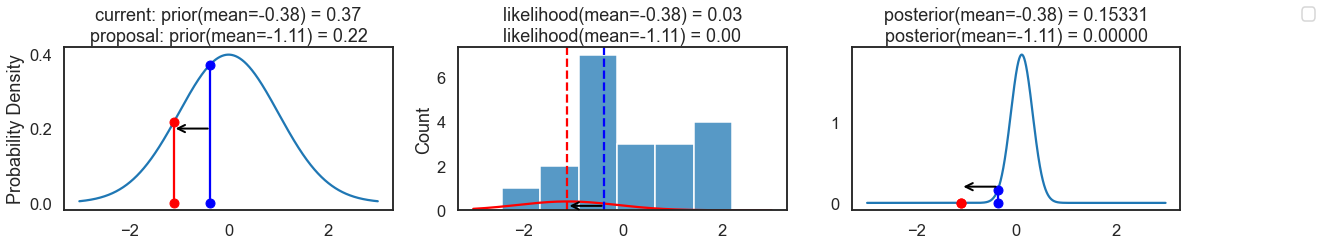

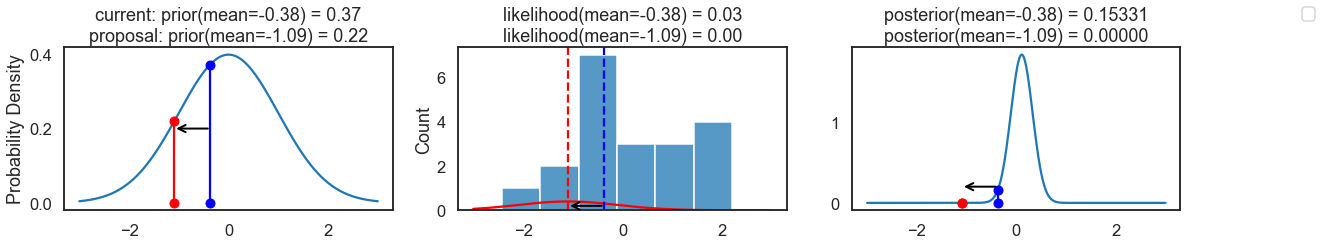

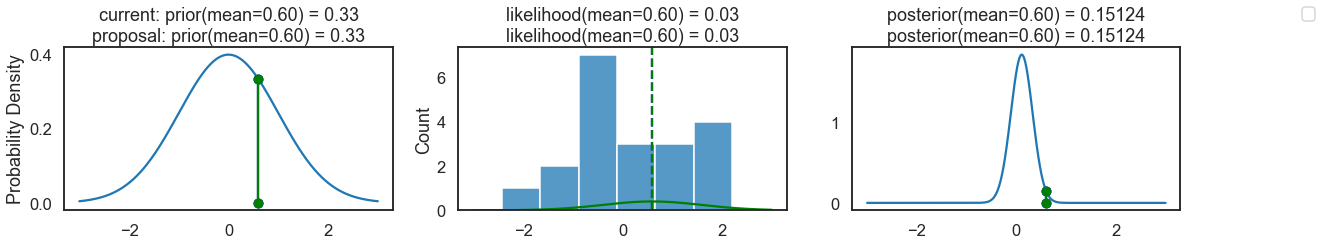

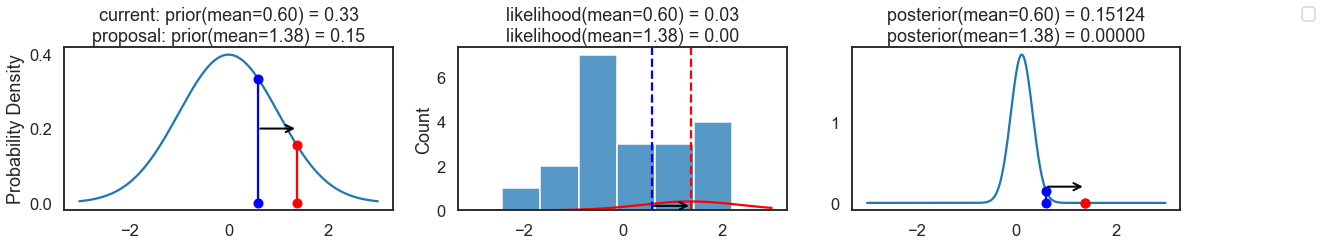

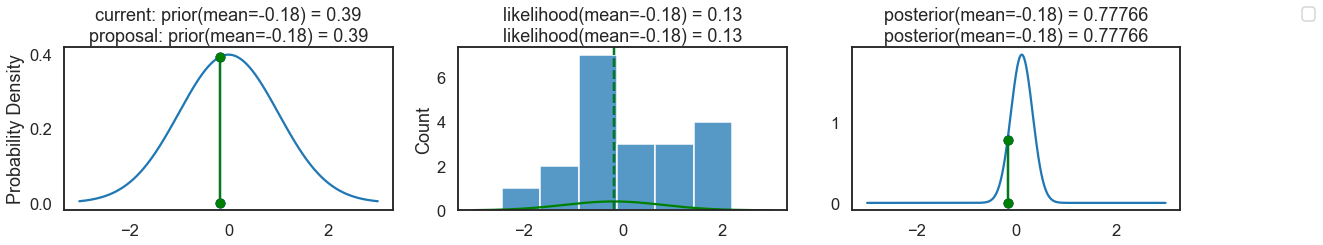

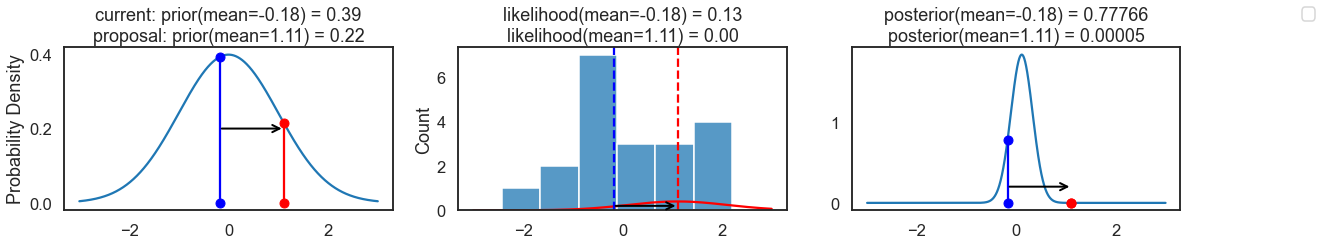

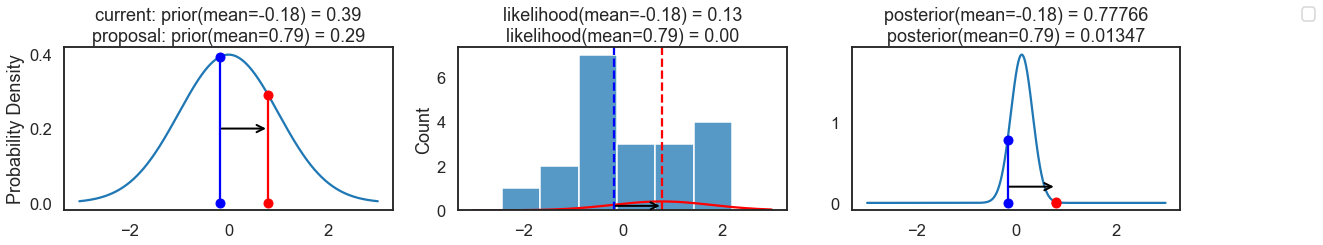

In [75]:
np.random.seed(123)
hamiltonian_sampler(data, samples=15, mu_init=-1., plot=True);

Draw samples from the posterior and plot them

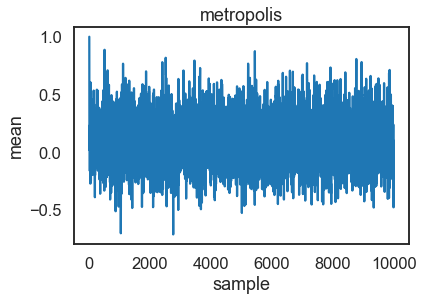

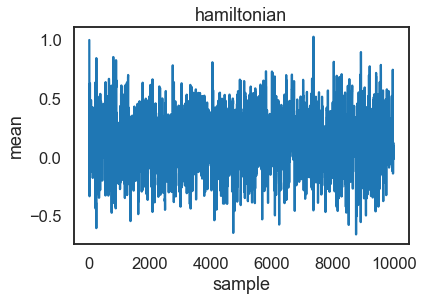

In [76]:
#Metropolis Hastings MCMC
posterior_metropolis = metropolis_sampler(data, samples=10000, mu_init=1.)
fig, ax = plt.subplots()
ax.plot(posterior_metropolis)
_ = ax.set(xlabel='sample', ylabel='mean', title ='metropolis');

#Hamiltonian MCMC
posterior_hamiltonian = hamiltonian_sampler(data, samples=10000, mu_init=1.)
fig, ax = plt.subplots()
ax.plot(posterior_hamiltonian)
_ = ax.set(xlabel='sample', ylabel='mean', title = 'hamiltonian');

Comparison of Metropolis MCMC approximate solution to analytical posterior

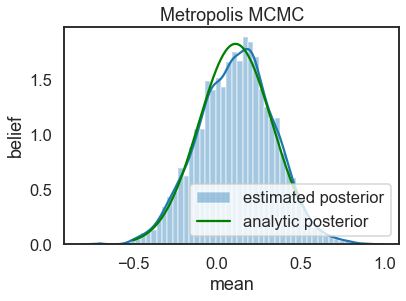

In [81]:
# Metropolis MCMC samples comparison with analytical posterior
ax = plt.subplot()
post = calc_posterior_analytical(data, x, 0, 1)
sns.distplot(posterior_metropolis[500:], ax=ax, label='estimated posterior')
x = np.linspace(-.5, .5, 500)

ax.plot(x, post, 'g', label='analytic posterior')
_ = ax.set(xlabel='mean', ylabel='belief', title='Metropolis MCMC');
ax.legend();



Comparison of Hamiltonian MCMC approximate solution to analytical posterior

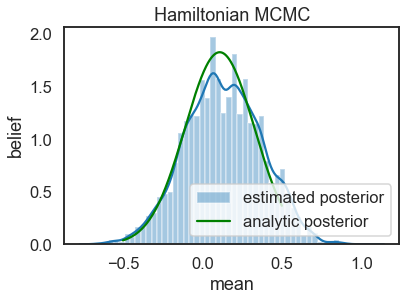

In [78]:
# Hamiltonian MCMC samples comparison with analytical posterior
ax = plt.subplot()

sns.distplot(posterior_hamiltonian[500:], ax=ax, label='estimated posterior')
x = np.linspace(-.5, .5, 500)
post = calc_posterior_analytical(data, x, 0, 1)
ax.plot(x, post, 'g', label='analytic posterior')
_ = ax.set(xlabel='mean', ylabel='belief', title='Hamiltonian MCMC');
ax.legend();


### Sensitivity to Proposal Width


We don't want the width to be too narrow because sampling will be inefficient as it takes a long time to explore the whole parameter space. We also should avould large proposal width as then we basically never accept a jump.

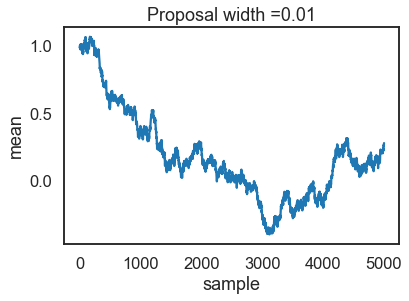

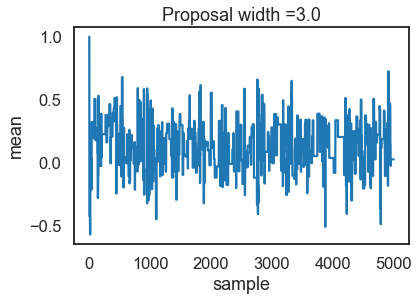

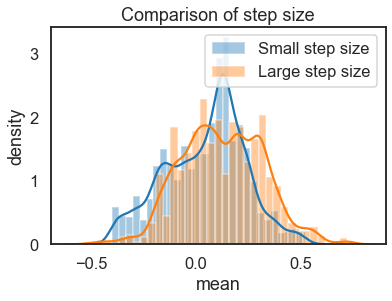

In [79]:
# Sensitivity to proposal width

# Sampling for large and small proposal widths
posterior_small = metropolis_sampler(data, samples=5000, mu_init=1., proposal_width=.01)
fig, ax = plt.subplots()
ax.plot(posterior_small);
_ = ax.set(xlabel='sample', ylabel='mean', title='Proposal width =0.01');

posterior_large = metropolis_sampler(data, samples=5000, mu_init=1., proposal_width=3.)
fig, ax = plt.subplots()
ax.plot(posterior_large); plt.xlabel('sample'); plt.ylabel('mu');
_ = ax.set(xlabel='sample', ylabel='mean', title='Proposal width =3.0');

#Plotting the sampled distributions for comparison
fig, ax = plt.subplots()
sns.distplot(posterior_small[1000:], label='Small step size')
sns.distplot(posterior_large[1000:], label='Large step size');
_ = ax.set(xlabel='mean', ylabel='density', title='Comparison of step size')
_ = plt.legend();


### Results

Metropolis MCMC gave mean of the posterior as 0.06 and the transition can be seen from the plots above. The Hamiltonian reached a solution in an earlier iteration with posterior mean as -0.38. But both of them generated good approximate estimation for the posterior mean and have been compared with the analytical posterior in the plot above. 

Optimum proposal width should be chosen and this effects the sampling process as can be seen from large and small widths plot above. Autocorrelation of samples (how correlated a sampl point is to other sample points) is a good metric to evaluate the efficiency of the sampler as we wan't our samples to be independent.

Proposal width was 0.5 for Metropolis and 0.01 for Hamiltonian.

We can have data from any different distribution  and still use the same algorithm and get the correct posterior.

### END

I am a PhD student with Institite for Geophysics at Department of Earth and Planetary Sciences, University of Texas at Austin. I work in areas of carbon capture and storage, inverse theory problem and uncertainty analysis using machine learning approaches. 
Currently, I am expanding myself towards high perfromace computing, quantum computing and generative AI techniques for geophysical problems.


I can be reached at sohini.dasgupta@utexas.edu.

My LinkedIn:  [LinkedIn](https://www.linkedin.com/in/sohini-dasgupta-02aa18146)


I am excited to build meaningful collaborations, learn and work on projects or internships in similar areas.


I hope this was helpful,

*Sohini Dasgupta*

___________________

#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
